# 第二章：日志文件清洗 Web log clean
- **Author**: wangfeicheng
- **Mail**:wang_feicheng@163.com or wangfeichengzjhw@huawei.com

本案例主要介绍如何从杂乱的web日志文件中进行数据清洗和预处理，从而提取网站的有效信息：如网页访问量、独立IP数、注册用户数等，为下一步进行用户画像和数据分析挖掘做好准备。

Tips：相应的方法可以结合自身处理的数据，尝试推广到自己的业务领域。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

##  数据介绍

本案例使用的是某网站给定时间内的log日志文件，数据记录包括：
- 访问的IP地址
- 访问时间
- 访问协议
- 访问状态码
- 请求体大小
- referer
- User Agent

In [2]:
line_01 = str()
with open('Data/access.log.txt') as log_file:
    i = 0
    for line in log_file.readlines()[0:5]:
        if i==1:
            line_01 =line
        i+=1
        print(line)

194.237.142.21 - - [18/Sep/2013:06:49:18 +0000] "GET /wp-content/uploads/2013/07/rstudio-git3.png HTTP/1.1" 304 0 "-" "Mozilla/4.0 (compatible;)"

183.49.46.228 - - [18/Sep/2013:06:49:23 +0000] "-" 400 0 "-" "-"

163.177.71.12 - - [18/Sep/2013:06:49:33 +0000] "HEAD / HTTP/1.1" 200 20 "-" "DNSPod-Monitor/1.0"

163.177.71.12 - - [18/Sep/2013:06:49:36 +0000] "HEAD / HTTP/1.1" 200 20 "-" "DNSPod-Monitor/1.0"

101.226.68.137 - - [18/Sep/2013:06:49:42 +0000] "HEAD / HTTP/1.1" 200 20 "-" "DNSPod-Monitor/1.0"



##  数据清洗 
通过数据清洗，将原始的log文件转换为规整的、有效的数据集


#### Step 1：提取访问的IP地址

In [3]:
def getIP(line):
    #input: line
    #output: 访问IP
    strs = line.split('- -')
    return strs[0].strip()
# getIP(line_01)

#### Step 2：提取访问时间

In [4]:
def getTime(line):
    #input: line
    #output: 访问时间
    import re
    import time
    pattern =re.compile(r'.*?\[(.*?)\].*?')      #使用正则表达式，匹配每行中的 [ ] 中的信息，从而提取时间信息
    time_info = re.match(pattern,line).group(1).split() 
    date_info = time_info[0].strip()             # 得到时间信息,如 '18/Sep/2013:06:49:18'
    timezone = time_info[1].strip()              # 得到时区信息
    timestamp = time.mktime(time.strptime(date_info,"%d/%b/%Y:%H:%M:%S")) # 从时间字符串转换为timestamp
    realtime_str = time.strftime("%Y/%m/%d %H:%M:%S",time.localtime(timestamp)) # 从timestamp转换为自己指定格式的时间字符串
    return realtime_str,timezone
# getTime(line_01)

#### Step 3: 提取请求Url和协议

In [5]:
def getRequestInfo(line):
    #inpout:line
    #output:url和协议，referer,user agent
    import re
    url_protocol,referer,user_agent =  re.findall(r'"(.*?)"',line)
    try:
        [method,url,protocol] = url_protocol.split(' ')
    except:
        [method,url,protocol] = [None,None,None]
    return method,url,protocol,referer,user_agent
getRequestInfo(line_01)

(None, None, None, '-', '-')

In [6]:
method,url,procotol,referer,user_agent = getRequestInfo(line_01)

#### step 4:提取访问状态码和请求体的大小

In [7]:
def getStatus(line):
    #input: line
    #output: response code and size
    import re
    status_info  = re.findall(r'.*?(\d+\s+\d+).*?',line)[0].split(' ')
    [response_code,size] = [s.strip() for s in status_info]
    return response_code,size
# getStatus(line_01)

### Step 5: 定义visitor类
用来封装提取的方法（procedure/method）和提取的信息（attribute）
- method:
 1. fit()
 1. get_ip()
 2. get_time()
 2. get_timezone()
 3. get_method()
 3. get_url()
 3. get_protocol()
 4. get_referer()
 4. get_status_code()
 4. get_size()
 5. show_info(): 打印相应的封装信息
 

- attributes
 1. IP
 2. Time
 3. TimeZoon
 4. method,
 5. url
 6. protocol
 7. referer
 8. user_agent
 9. response_code
 10. response_size


In [8]:
line_01

'183.49.46.228 - - [18/Sep/2013:06:49:23 +0000] "-" 400 0 "-" "-"\n'

In [9]:
log_dir = 'data/access.log.txt'
class visitor():
    def __init__(self):
        self.log_info = None
            #Define the attribute for the class
        self.log_info = None
        self.IP = None
        self.TIME = None
        self.TIMEZONE = None
        self.METHOD = None
        self.URL = None
        self.PROCOTOL = None
        self.USER_AGENT = None
        self.STATUS_CODE = None
        self.SIZE = None
        
    def fit(self,log_dir):
        info_list =[]
        with open(log_dir) as log_file:
            for line in log_file.readlines():
                ip = getIP(line)
                time,timezone =getTime(line)
                method,url,procotol,referer,user_agent= getRequestInfo(line)
                status_code,size = getStatus(line)
                info = [ip,time,timezone,method,url,procotol,user_agent,status_code,size]
                info_list.append(info)
        # info_list[0:10]
        info_df = pd.DataFrame(info_list,
                               columns=['IP','TIME','TIMEZONE','METHOD','URL','PROCOTOL','USER_AGENT','STATUS_CODE','SIZE'])
        self.log_info = info_df
        self.log_info = info_df
        self.IP = info_df.IP
        self.TIME = info_df.TIME
        self.TIMEZONE = info_df.TIMEZONE
        self.METHOD =info_df.METHOD
        self.URL = info_df.URL
        self.PROCOTOL = info_df.PROCOTOL
        self.USER_AGENT = info_df.USER_AGENT
        self.STATUS_CODE = info_df.STATUS_CODE
        self.SIZE = info_df.SIZE



    #define the methods of the class
    def show_info(self):
        return self.log_info.info()
    def get_logInfo(self):
        return self.log_info
    def get_ip(self):
        return self.IP
    def get_time(self):
        return self.TIME
    def get_timezone(self):
        return self.TIMEZONE
    def get_method(self):
        return self.METHOD
    def get_url(self):
        return self.URL
    def get_protocol(self):
        return self.PROCOTOL
    def get_userAgent(self):
        return self.USER_AGENT
    def get_statusCode(self):
        return self.STATUS_CODE
    def get_size(self):
        return self.SIZE

In [10]:
# create a instance from the class
log = visitor()
#fit on the dir
log.fit(log_dir)

In [11]:
log.log_info.head()

,IP,TIME,TIMEZONE,METHOD,URL,PROCOTOL,USER_AGENT,STATUS_CODE,SIZE
0,194.237.142.21,2013/09/18 06:49:18,+0000,GET,/wp-content/uploads/2013/07/rstudio-git3.png,HTTP/1.1,Mozilla/4.0 (compatible;),304,0
1,183.49.46.228,2013/09/18 06:49:23,+0000,None,None,None,-,400,0
2,163.177.71.12,2013/09/18 06:49:33,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
3,163.177.71.12,2013/09/18 06:49:36,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
4,101.226.68.137,2013/09/18 06:49:42,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20


In [12]:
log.show_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14619 entries, 0 to 14618
Data columns (total 9 columns):
IP             14619 non-null object
TIME           14619 non-null object
TIMEZONE       14619 non-null object
METHOD         13770 non-null object
URL            13770 non-null object
PROCOTOL       13770 non-null object
USER_AGENT     14619 non-null object
STATUS_CODE    14619 non-null object
SIZE           14619 non-null object
dtypes: object(9)
memory usage: 1.0+ MB


In [13]:
log.get_ip()[0:10]

0     194.237.142.21
1      183.49.46.228
2      163.177.71.12
3      163.177.71.12
4     101.226.68.137
5     101.226.68.137
6       60.208.6.156
7     222.68.172.190
8     222.68.172.190
9    183.195.232.138
Name: IP, dtype: object

# 统计分析 

### Step 1： IP地址统计分析

In [14]:
ip = log.get_ip()
print('The lenth of ip is {0}'.format(ip.size))
print('_'*80)
print('_'*80)
print('_'*80)
print('The top 10 most fequent ip are as follows:\n{0}'.format(ip.value_counts()[0:10]))

The lenth of ip is 14619
________________________________________________________________________________
________________________________________________________________________________
________________________________________________________________________________
The top 10 most fequent ip are as follows:
163.177.71.12      972
101.226.68.137     972
183.195.232.138    971
111.192.165.229    377
114.252.89.91      374
66.249.66.84       246
222.70.152.149     226
220.181.89.174     172
111.194.118.58     160
60.247.77.253      146
Name: IP, dtype: int64


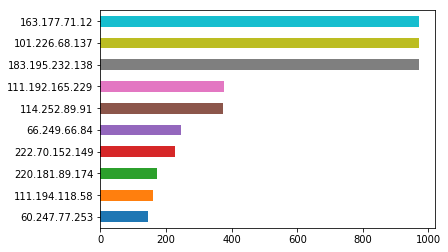

In [15]:
top10_ip = ip.value_counts()[0:10]
top10_ip[::-1].plot(kind = 'barh')

## Step 3: 根据 STATUS_CODE 字段进行过滤
因为 STATUS_CODE >=400 ，表示访问失败，是无效数据，因此需要过滤

In [16]:
# 因为 STATUS_CODE >=400 ，表示访问失败，是无效数据，因此需要过滤
log_df = log.get_logInfo()
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14619 entries, 0 to 14618
Data columns (total 9 columns):
IP             14619 non-null object
TIME           14619 non-null object
TIMEZONE       14619 non-null object
METHOD         13770 non-null object
URL            13770 non-null object
PROCOTOL       13770 non-null object
USER_AGENT     14619 non-null object
STATUS_CODE    14619 non-null object
SIZE           14619 non-null object
dtypes: object(9)
memory usage: 1.0+ MB


In [17]:
log_df.STATUS_CODE = log_df.STATUS_CODE.astype('int')
useful_log = log_df[log_df.STATUS_CODE <400]
useful_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13535 entries, 0 to 14618
Data columns (total 9 columns):
IP             13535 non-null object
TIME           13535 non-null object
TIMEZONE       13535 non-null object
METHOD         13535 non-null object
URL            13535 non-null object
PROCOTOL       13535 non-null object
USER_AGENT     13535 non-null object
STATUS_CODE    13535 non-null int32
SIZE           13535 non-null object
dtypes: int32(1), object(8)
memory usage: 1004.6+ KB


In [18]:
useful_log.head()

,IP,TIME,TIMEZONE,METHOD,URL,PROCOTOL,USER_AGENT,STATUS_CODE,SIZE
0,194.237.142.21,2013/09/18 06:49:18,+0000,GET,/wp-content/uploads/2013/07/rstudio-git3.png,HTTP/1.1,Mozilla/4.0 (compatible;),304,0
2,163.177.71.12,2013/09/18 06:49:33,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
3,163.177.71.12,2013/09/18 06:49:36,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
4,101.226.68.137,2013/09/18 06:49:42,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
5,101.226.68.137,2013/09/18 06:49:45,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20


### Step 4：显示有效的IP


163.177.71.12      972
101.226.68.137     972
183.195.232.138    971
111.192.165.229    334
114.252.89.91      294
66.249.66.84       246
220.181.89.174     169
222.70.152.149     160
111.194.118.58     159
219.142.118.249    123
Name: IP, dtype: int64


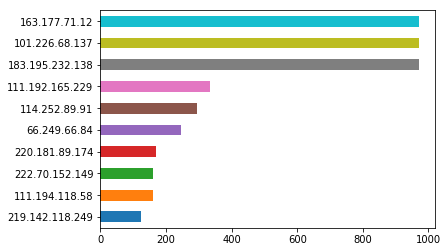

In [19]:
top10_usefulIP = useful_log.IP.value_counts()[0:10]
print(top10_usefulIP)
top10_usefulIP[::-1].plot(kind='barh')

### Step 5： 显示有效的url 访问量

/wp-includes/js/jquery/jquery-migrate.min.js?ver=1.2.1    361
/wp-includes/js/jquery/jquery.js?ver=1.10.2               358
/js/baidu.js                                              318
/wp-admin/admin-ajax.php                                  308
/js/google.js                                             308
/wp-content/themes/silesia/js/jquery.cycle.all.min.js     293
/wp-content/themes/silesia/functions/js/shortcode.js      290
/wp-content/themes/silesia/js/load.js                     290
/wp-includes/js/comment-reply.min.js?ver=3.6              285
/feed/                                                    263
Name: URL, dtype: int64


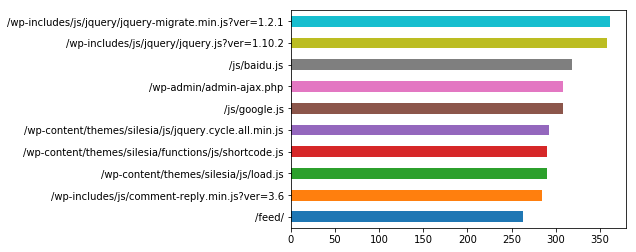

In [20]:
top10_url = useful_log.URL.value_counts()[1:11]
print(top10_url)
top10_url[::-1].plot(kind='barh')

#### 显示user agent的使用情况

DNSPod-Monitor/1.0                                                                                                         2915
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.66 Safari/537.36                764
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.95 Safari/537.36                676
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.66 Safari/537.36                       611
Mozilla/4.0                                                                                                                 321
Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.66 Safari/537.36                287
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:23.0) Gecko/20100101 Firefox/23.0                                                    251
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)                                

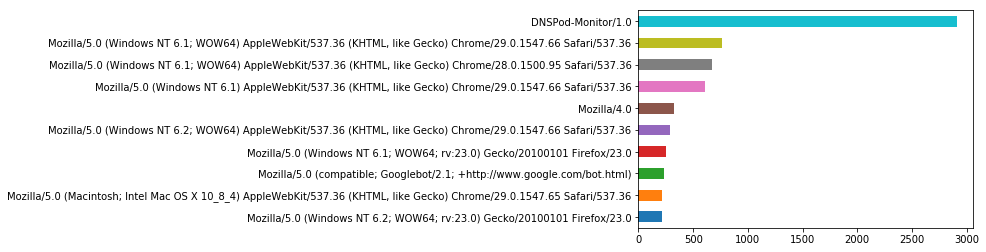

In [21]:
top10_userAgent = useful_log.USER_AGENT.value_counts()[0:10]
print(top10_userAgent)
top10_userAgent[::-1].plot(kind = 'barh')

### Step 6: 时间维度分析

In [22]:
from datetime import datetime

In [23]:
useful_log.head()

,IP,TIME,TIMEZONE,METHOD,URL,PROCOTOL,USER_AGENT,STATUS_CODE,SIZE
0,194.237.142.21,2013/09/18 06:49:18,+0000,GET,/wp-content/uploads/2013/07/rstudio-git3.png,HTTP/1.1,Mozilla/4.0 (compatible;),304,0
2,163.177.71.12,2013/09/18 06:49:33,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
3,163.177.71.12,2013/09/18 06:49:36,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
4,101.226.68.137,2013/09/18 06:49:42,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20
5,101.226.68.137,2013/09/18 06:49:45,+0000,HEAD,/,HTTP/1.1,DNSPod-Monitor/1.0,200,20


In [24]:
useful_log.index = pd.to_datetime(useful_log.TIME)

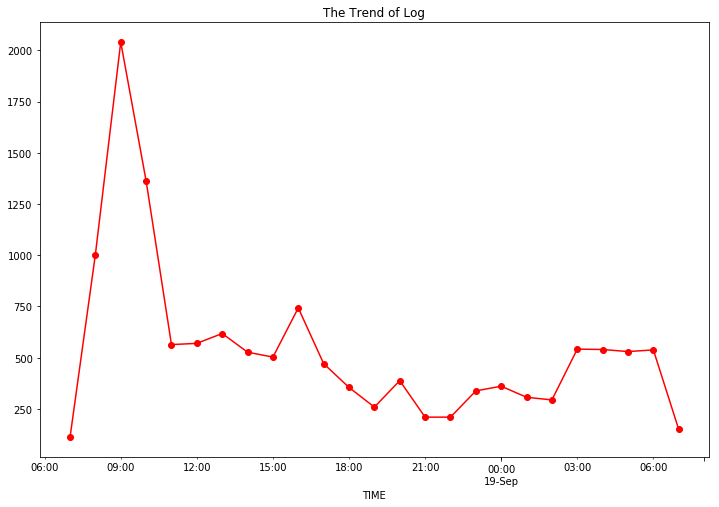

In [25]:
counts_hourly = useful_log['IP'].resample('h',closed ='left',label='right').count()
counts_hourly.plot(c ='r',marker = 'o',figsize = (12,8),title = 'The Trend of Log')